In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import KFold
import numpy as np

## Read in data
Seperating the attributes from the result

In [2]:
file = pd.read_csv("heart_data.txt")

cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
data = pd.DataFrame([file[col] for col in cols]).T
famhist = [1 if val == 'Present' else 0 for val in file['famhist']]
data['famhist'] = famhist
data = pd.DataFrame(zscore(data, ddof=1))
cols.append('famhist')
data.columns = cols

data

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.184570
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,-0.842361
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1.184570
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.184570
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.184570
...,...,...,...,...,...,...,...,...,...
457,3.692037,-0.704470,0.598614,0.811401,1.109862,0.570971,-0.696228,1.039361,-0.842361
458,2.130781,0.122871,-0.159507,0.860240,-0.112441,0.608942,0.068445,0.628654,-0.842361
459,-1.479624,-0.138395,-1.521228,-1.307946,-1.334744,-1.413043,0.391960,0.834008,-0.842361
460,-0.991731,0.384137,3.317227,0.691875,1.109862,0.309916,0.282897,-0.192760,-0.842361


## NN loop
This is the actual loop running the machine learning model

In [3]:
def ANN_model(
        epochs: int, 
        h: int, 
        x_data: object, 
        y_data: object,
        train_idx: list,
        test_idx: list, 
        n_input: int = len(data.columns), 
        n_out: int = 1, 
        lr: float = 0.1
    ):
    """
    Function for running (training and testing) ANN model for each k-fold or subset of k-folds
    """
    
    train_loss, test_loss = np.zeros(shape=(epochs)), np.zeros(shape=(epochs))
        
    # Defining the model for each fold
    model = nn.Sequential(nn.Linear(n_input, h),
                          nn.Linear(h, n_out),
                          nn.ReLU())
    loss_function = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Getting the k-folded data
    x_train, x_test = map(torch.tensor, ((x_data.iloc[train_idx].values), (x_data.iloc[test_idx].values)))
    y_train, y_test = map(torch.tensor, ((y_data.iloc[train_idx].values), (y_data.iloc[test_idx].values)))
    x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()
    
    # Running model
    for i in range(epochs):
        pred_y = model(x_train)
        loss = loss_function(pred_y.flatten(), y_train)
        train_loss[i] = loss

        pred_y_test = model(x_test)
        loss_test = loss_function(pred_y_test.flatten(), y_test)
        test_loss[i] = loss_test
        
        model.zero_grad()
        loss.backward()

        optimizer.step()
    
    return train_loss, test_loss


In [4]:
def kfold_iterations(x_data: object, y_data: object, epochs: int, hidden_neurons: list, k: int = 10):
    
    best_model = np.zeros(shape=k) # The number of hidden neurons for the best models will be stored here
    E_i_NN, final_train_error = np.zeros(shape=k), np.zeros(shape=k) # Error for best model in each k-fold will be stored here
    splits_outer = KFold(n_splits = k, shuffle=True, random_state=42) # Defining outer splits
    
    for i, (train_idx_outer, test_idx_outer) in enumerate(splits_outer.split(x_data)): # Outer k-fold layer
        
        # Getting "new" data set for inner k-folds
        x_train_outer = x_data.iloc[train_idx_outer]
        y_train_outer = y_data.iloc[train_idx_outer]
        
        k_inner = len(hidden_neurons) # Make as many k-folds as there are hidden neurons
        splits_inner = KFold(n_splits = k_inner, shuffle=True, random_state=42) # Defining inner splits
        
        error_measure = np.zeros(shape=k_inner) # Error for each inner layer will be stored here
        
        for j, (train_idx_inner, test_idx_inner) in enumerate(splits_inner.split(x_train_outer)): # Inner k-fold layer
            
            # Training models on inner k-folds
            _, test_loss = ANN_model(epochs, 
                                     hidden_neurons[j],
                                     x_train_outer, 
                                     y_train_outer,
                                     train_idx_inner,
                                     test_idx_inner
                                    )
            
            # We're only interested in the last test error, 
            # as this defines the total loss for the given model
            error_measure[j] = test_loss[-1] 
            
            '''
            Put a function here that runs the linear regression or logistic regression
            for inner k-folds and find the best lambda value for each outer k-fold
            '''
            
            
        
        # Run model again for outer layer with best h-value from inner layers
        h_best = hidden_neurons[np.argmax(error_measure)]
        train_loss, test_loss = ANN_model(epochs, 
                                 h_best,
                                 x_data, 
                                 y_data,
                                 train_idx_outer,
                                 test_idx_outer
                                )
        
        '''
        Again put the linear or logistic regression model here 
        but this time evaluate on the outer k-fold
        '''
        
        best_model[i] = h_best
        E_i_NN[i] = test_loss[-1] # Appending last value for test loss in outer layer, this value will go in the final table
        final_train_error[i] = train_loss[-1]
    
    return final_train_error, E_i_NN, best_model

In [5]:
# Run the whole chebang!! (should take less than 30s)
hidden_neurons = np.arange(0, 30, 2) + 1
train_errors, test_errors, best_model = kfold_iterations(data, file['chd'], epochs=200, hidden_neurons=hidden_neurons)

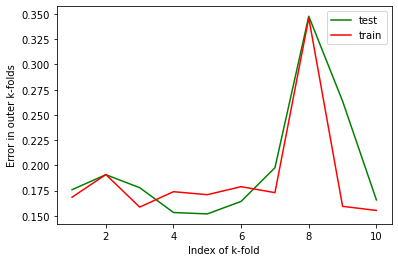

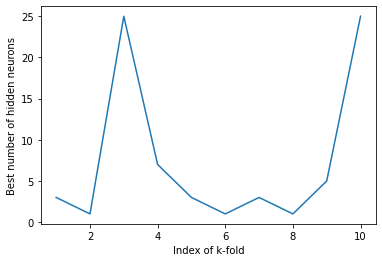

In [6]:
indices = np.arange(1, 11, 1)
plt.plot(indices, test_errors, 'g', label="test")
plt.plot(indices, train_errors, 'r', label="train")
plt.legend()
plt.xlabel("Index of k-fold")
plt.ylabel("Error in outer k-folds")
plt.show()
plt.plot(indices, best_model)
plt.xlabel("Index of k-fold")
plt.ylabel("Best number of hidden neurons")
plt.show()